In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df_train = pd.read_parquet('train.parquet', engine= 'pyarrow')

PROCESAMIENTO DE LOS DATOS

In [ ]:
#Empezamos observando la estructura del dataset
df_train.shape

(346479, 22)

In [ ]:
# Los diferentes tipos de datos que disponemos
df_train.dtypes

id                           int64
url                         object
region                      object
region_url                  object
price                        int64
type                        object
sqfeet                       int64
beds                         int64
baths                      float64
cats_allowed                 int64
dogs_allowed                 int64
smoking_allowed              int64
wheelchair_access            int64
electric_vehicle_charge      int64
comes_furnished              int64
laundry_options             object
parking_options             object
image_url                   object
description                 object
lat                        float64
long                       float64
state                       object
dtype: object

In [ ]:
# Comenzamos a recorrer la columna que mas nos interesa, observando diferentes metricas
df_train['price'].describe()

count    3.464790e+05
mean     9.664420e+03
std      4.703573e+06
min      0.000000e+00
25%      8.050000e+02
50%      1.036000e+03
75%      1.395000e+03
max      2.768307e+09
Name: price, dtype: float64

In [ ]:
df_train['price'].sort_values().head()

45823     0
313791    0
304905    0
17761     0
300862    0
Name: price, dtype: int64

In [ ]:
df_train['price'].sort_values().tail()

297036      12000000
265155      18502000
79076       18502000
98438       21701907
106214    2768307249
Name: price, dtype: int64

In [16]:
# Creamos la columna objetivo
df_train['category_price'] = df_train['price'].apply(lambda x: 0 if x < 1000 else 1)
#low = 0
#medium = 1
#righ = 1

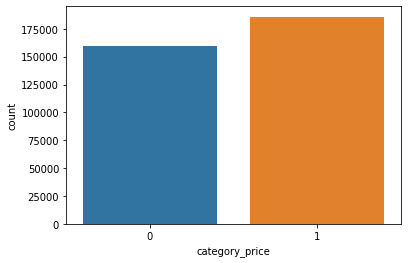

In [19]:
sns.countplot(x='category_price', data=df_train)
plt.show()

In [20]:
# Nos quedamos con las columnas que mas nos interesan
data = df_train[['price', 'description', 'category_price']].copy()

In [21]:
# Pasamos a miniscula todas las letras de la columna 'description
data['description'] = data['description'].str.lower()

In [23]:
# Eliminamos los datos nulos
data.dropna(subset = ['price'], inplace = True)
data.dropna(subset = ['description'],inplace = True)

In [ ]:
data.shape

(345302, 3)

MODELIZACION

In [11]:
# Descargamos el modulo 'stopwords' para asi poder tokenizar los datos de nuestra columna 'description'
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [ ]:
sw = nltk.corpus.stopwords.words('english')
# Nos quedamos con la lista de los textos de las descripciones
corpus = data['description']
# Lo convertimos a lista
corpus = list(corpus)
# Instanciamos el vectorizador con los stopwords y un máximo de features de 1000
vectorizer = TfidfVectorizer(stop_words=sw, max_features=1000)
# Vectorizamos los datos
x = vectorizer.fit_transform(corpus)
# Vemos la cantidad de datos obtenidos
# Obtenemos la variable objetivo
y = data['category_price']

In [ ]:
# Observamos como quedaron las estructuras de nuestras nuevas variables
x.shape

(345302, 1000)

In [ ]:
y.shape

(345302,)

CREACION DE NUESTRO PIPELINE

In [27]:
# Importaciones
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.pipeline import Pipeline
import joblib

In [ ]:
pipe_rf = Pipeline([('rf', RandomForestClassifier(n_estimators=50, random_state=0)),])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Entrenamos nuestro modelo
pipe_rf.fit(x_train, y_train)

Pipeline(steps=[('rf',
                 RandomForestClassifier(n_estimators=50, random_state=0))])

In [ ]:
joblib.dump(pipe_rf, 'modelo_random_forest01.pkl', compress=1)

['modelo_random_forest01.pkl']

In [25]:
rf = joblib.load('modelo_random_forest01.pkl')

In [ ]:
y_pred = rf.predict(x_test)

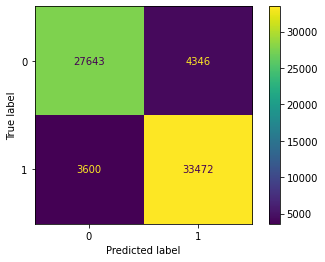

In [ ]:
# Visualizamos el desempeño de nuestro algoritmo
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
disp.plot()

In [ ]:
rs = recall_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

print(f'Recall: {rs}')
print(f'Precision: {ps}')
print(f'Accuracy: {ac}')

Recall: 0.9028916702632714
Precision: 0.8850811782748955
Accuracy: 0.8849422973892646


ARCHIVO TEST


In [7]:
data_t = pd.read_parquet('test.parquet', engine= 'pyarrow')

In [8]:
# Obtenemos los índices de los registros con descripciones vacías
sin_desc = data_t[data_t.description.isnull()].index

In [9]:
# Vemos si hay nulos en la columna 'description'
data_t['description'].isnull().sum()

0

In [12]:
# Obtenemos los stopwords
sw = nltk.corpus.stopwords.words('english')
# Nos quedamos con la lista de los textos de las descripciones
corpus_t = data_t['description']
# Lo convertimos a lista
corpus_t = list(corpus_t)

In [14]:
# Instanciamos el vectorizador con los stopwords y un máximo de features de 1000
vectorizer_t = TfidfVectorizer(stop_words=sw, max_features=1000)
# Vectorizamos los datos
x_t = vectorizer_t.fit_transform(corpus_t)

In [30]:
#realizamos el predict
y_t_predict = rf.predict(x_t)


GENERACION DEL CSV

In [31]:
# Creamos el DataFrame que contendrá las predicciones obtenidas
datos = pd.DataFrame()
# Creamos la columna pred con los datos obtendiso de la predicción
datos['pred'] = y_t_predict
# Lo guardamos con formato CSV
datos.to_csv('BuhoCosmico.csv', index=False)